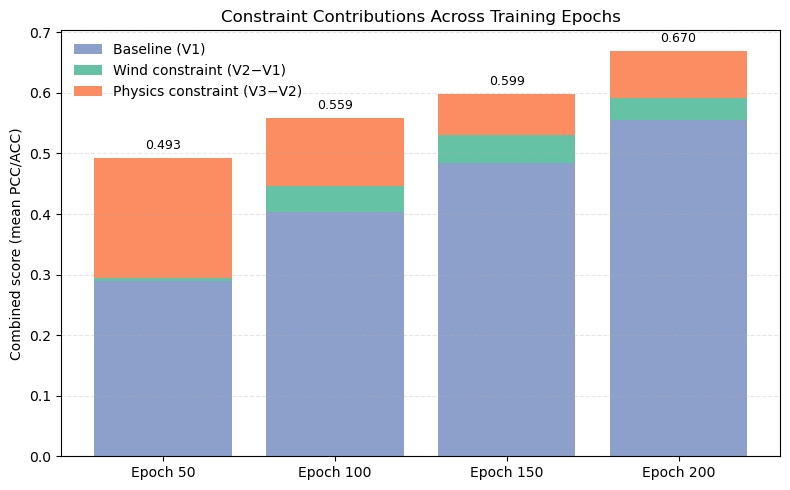

Saved stacked contribution chart to /home/CanglongPhysics/figures/evaluation/model_constraints_ablation.png


In [1]:
"""Simple ablation visualization for Canglong model family.

Designed so the whole script can be copy-pasted into a notebook. When running in
plain Python it auto-detects project paths; inside a notebook override the
``CSV_PATH`` and ``OUTPUT_DIR`` variables near the top.
"""

import os
import re
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager


# ---------------------------------------------------------------------------
# Path configuration (make these tweaks when copying into a notebook)
# ---------------------------------------------------------------------------

if '__file__' in globals():  # script execution
    _default_root = Path(__file__).resolve().parents[2]
else:  # notebook fallback
    _default_root = Path.cwd()

PROJECT_ROOT = _default_root
CSV_PATH = PROJECT_ROOT / 'data' / 'model_raw_performance.CSV'
OUTPUT_DIR = PROJECT_ROOT / 'figures' / 'evaluation'


def read_combined_scores(path: Path):
    if not path.exists():
        raise FileNotFoundError(f'Cannot find performance CSV at {path}')

    scores = {}
    current_epoch = None

    with path.open('r', encoding='utf-8') as handle:
        for raw_line in handle:
            line = raw_line.strip()
            if not line:
                continue

            if line.startswith('V1_epoch'):
                epoch_match = re.search(r'epoch(\d+)', line)
                if epoch_match is None:
                    continue
                current_epoch = epoch_match.group(1)
                scores[current_epoch] = {}
                continue

            if current_epoch is None:
                continue

            if line.startswith('Combined score (mean PCC/ACC):'):
                values = []
                for item in line.split(','):
                    try:
                        values.append(float(item.split(':')[-1]))
                    except ValueError:
                        pass
                if len(values) == 3:
                    scores[current_epoch]['combined'] = values

    return scores


def build_contributions(score_map):
    epochs = sorted(score_map.keys(), key=int)
    base = []
    wind = []
    physics = []
    totals = []

    for epoch in epochs:
        combined = score_map[epoch].get('combined')
        if combined is None:
            raise ValueError(f'Missing combined score for epoch {epoch}')
        v1, v2, v3 = combined
        base.append(v1)
        wind.append(v2 - v1)
        physics.append(v3 - v2)
        totals.append(v3)

    return epochs, np.array(base), np.array(wind), np.array(physics), np.array(totals)


def configure_fonts():
    font_path = Path('/usr/share/fonts/arial/ARIAL.TTF')
    if font_path.exists():
        font_manager.fontManager.addfont(str(font_path))
        mpl.rcParams['font.family'] = 'Arial'


def main(csv_path: Path = CSV_PATH, output_dir: Path = OUTPUT_DIR):
    configure_fonts()

    score_map = read_combined_scores(csv_path)
    epochs, base, wind, physics, totals = build_contributions(score_map)

    x = np.arange(len(epochs))

    fig, ax = plt.subplots(figsize=(8, 5))

    colors = {
        'baseline': '#8da0cb',
        'wind': '#66c2a5',
        'physics': '#fc8d62'
    }

    ax.bar(x, base, color=colors['baseline'], label='Baseline (V1)')

    cumulative = base.copy()

    wind_bottom = np.where(wind >= 0, cumulative, cumulative + wind)
    ax.bar(x, wind, bottom=wind_bottom, color=colors['wind'], label='Wind constraint (V2−V1)')
    cumulative += wind

    physics_bottom = np.where(physics >= 0, cumulative, cumulative + physics)
    ax.bar(x, physics, bottom=physics_bottom, color=colors['physics'], label='Physics constraint (V3−V2)')
    cumulative += physics

    for idx, total in enumerate(totals):
        ax.text(x[idx], total + 0.01, f'{total:.3f}', ha='center', va='bottom', fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels([f'Epoch {epoch}' for epoch in epochs])
    ax.set_ylabel('Combined score (mean PCC/ACC)')
    ax.set_title('Constraint Contributions Across Training Epochs')
    ax.legend(frameon=False)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    os.makedirs(output_dir, exist_ok=True)
    fig_path = output_dir / 'model_constraints_ablation.png'
    plt.tight_layout()
    fig.savefig(fig_path, dpi=300)
    plt.show()
    print(f'Saved stacked contribution chart to {fig_path}')


if __name__ == '__main__':
    main()
